# Keyword Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import json
import pandas as pd
from sqlalchemy import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import gensim
import sys
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import ast
from nltk.corpus import wordnet

In [3]:
sqlite_path = "./reddit_ed_0.6.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread":False},
)

# Lemmatized 

In [4]:
lemmatized_normalized_dir = "./polarities/lemmatized_normalized"

In [5]:
subreddits = list()

In [6]:
subreddit_polarities = dict()
for subreddit in os.listdir(lemmatized_normalized_dir):
    if subreddit.split('.')[-1] == 'json':
        if subreddit.split('_standardized')[0] != 'BingeEatingRecovery' and subreddit.split('_standardized')[0] != 'selftext':
            with open(os.path.join(lemmatized_normalized_dir,subreddit)) as f:
                subreddit_polarities[subreddit.split('_standardized')[0]] = json.load(f)
                subreddits.append(subreddit.split('_standardized')[0])

In [7]:
subreddit_polarities.keys()

dict_keys(['AnorexiaRecovery', 'bingeeating', 'eating_disorders', 'EdAnonymousAdults', 'EatingDisorderHope', 'bulimia', 'BulimiaRecovery', 'EDRecovery_public', 'BingeEatingDisorder', 'EatingDisorders', 'anorexiaflareuphelp', 'edsupport', 'PurgingDisorder', 'AnorexiaNervosa', 'BulimiaAndAnaSupport', 'EDAnonymous', 'NotOtherwiseSpecified'])

In [8]:
subreddits

['AnorexiaRecovery',
 'bingeeating',
 'eating_disorders',
 'EdAnonymousAdults',
 'EatingDisorderHope',
 'bulimia',
 'BulimiaRecovery',
 'EDRecovery_public',
 'BingeEatingDisorder',
 'EatingDisorders',
 'anorexiaflareuphelp',
 'edsupport',
 'PurgingDisorder',
 'AnorexiaNervosa',
 'BulimiaAndAnaSupport',
 'EDAnonymous',
 'NotOtherwiseSpecified']

In [9]:
common = list(subreddit_polarities[subreddits[0]].keys())
for subreddit in subreddits:
#     print(subreddit)
    common = [value for value in common if value in subreddit_polarities[subreddit].keys()]

In [10]:
df_list = list()
for word in common:
    for subreddit in subreddits:
        df_list.append({'subreddit': subreddit, 'word': word, 'polarity': subreddit_polarities[subreddit][word]})

In [11]:
shared_words = pd.DataFrame.from_dict(df_list)

In [12]:
keywords = [
    "eat",
    "drink",
    "food",
    "gain", 
    "lose",
    "weight", 
    "exercise", 
    "recovery",
    "relapse",
    "therapy",
    "hospital",
    "doctor",
    "nurse",
    "body",
    "family",
    "mom",
    "dad"
]

In [13]:
keyword_scores = dict()

In [14]:
for keyword in keywords:
    keyword_scores[keyword] = dict()
    query = f"select subreddit, cast(count(*) as varchar) as num_submissions_with_word from subreddit_submission_metadata where selftext like '% {keyword} %' and subreddit != 'BingeEatingRecovery' and subreddit != 'selftext' group by subreddit;"
    num_submissions_with_word = pd.read_sql_query(text(query),con=engine.connect())
    
    subreddit_tuples = list(num_submissions_with_word.itertuples(index=False, name=None))
    
    for subreddit in subreddits:
        if subreddit not in num_submissions_with_word['subreddit'].tolist():
            subreddit_tuples.append((subreddit,'0'))
            
    print('\n',subreddit_tuples,'\n')
    
    sub_list = list()
        
    for tup in subreddit_tuples:
        sub_list.append(': '.join(tup))
        
#     print('\n',sub_list,'\n')
    
#     combo = [": ".join(item) for item in zip(subreddits,sub_list)]

    for subreddit in sub_list:
        if keyword in subreddit_polarities[subreddit.split(': ')[0]].keys():
            keyword_scores[keyword][subreddit] = subreddit_polarities[subreddit.split(': ')[0]][keyword]
        else:
            keyword_scores[keyword][subreddit] = 0
#             print(keyword, subreddit)
#             q = f"select selftext from subreddit_submission_metadata where subreddit='{subreddit.split(': ')[0]}' and selftext like '% {keyword} %';"
#             d = pd.read_sql_query(text(q),con=engine.connect())
#             print(d['selftext'].tolist())
            


 [('AnorexiaNervosa', '285'), ('AnorexiaRecovery', '642'), ('BingeEatingDisorder', '95'), ('BulimiaAndAnaSupport', '21'), ('BulimiaRecovery', '2'), ('EDAnonymous', '991'), ('EDRecovery_public', '137'), ('EatingDisorderHope', '22'), ('EatingDisorders', '374'), ('EdAnonymousAdults', '821'), ('NotOtherwiseSpecified', '1'), ('PurgingDisorder', '1'), ('anorexiaflareuphelp', '1'), ('bingeeating', '92'), ('bulimia', '438'), ('eating_disorders', '1077'), ('edsupport', '8')] 


 [('AnorexiaNervosa', '12'), ('AnorexiaRecovery', '35'), ('BingeEatingDisorder', '14'), ('BulimiaAndAnaSupport', '3'), ('EDAnonymous', '95'), ('EDRecovery_public', '5'), ('EatingDisorderHope', '4'), ('EatingDisorders', '19'), ('EdAnonymousAdults', '97'), ('bingeeating', '7'), ('bulimia', '47'), ('eating_disorders', '76'), ('BulimiaRecovery', '0'), ('anorexiaflareuphelp', '0'), ('edsupport', '0'), ('PurgingDisorder', '0'), ('NotOtherwiseSpecified', '0')] 


 [('AnorexiaNervosa', '170'), ('AnorexiaRecovery', '405'), ('Bin

# Graphs

In [19]:
for keyword in keyword_scores:
#     keyword_scores[keyword].pop('selftext')
    keyword_scores[keyword] = dict(sorted(keyword_scores[keyword].items(), key=lambda item: item[1]))

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


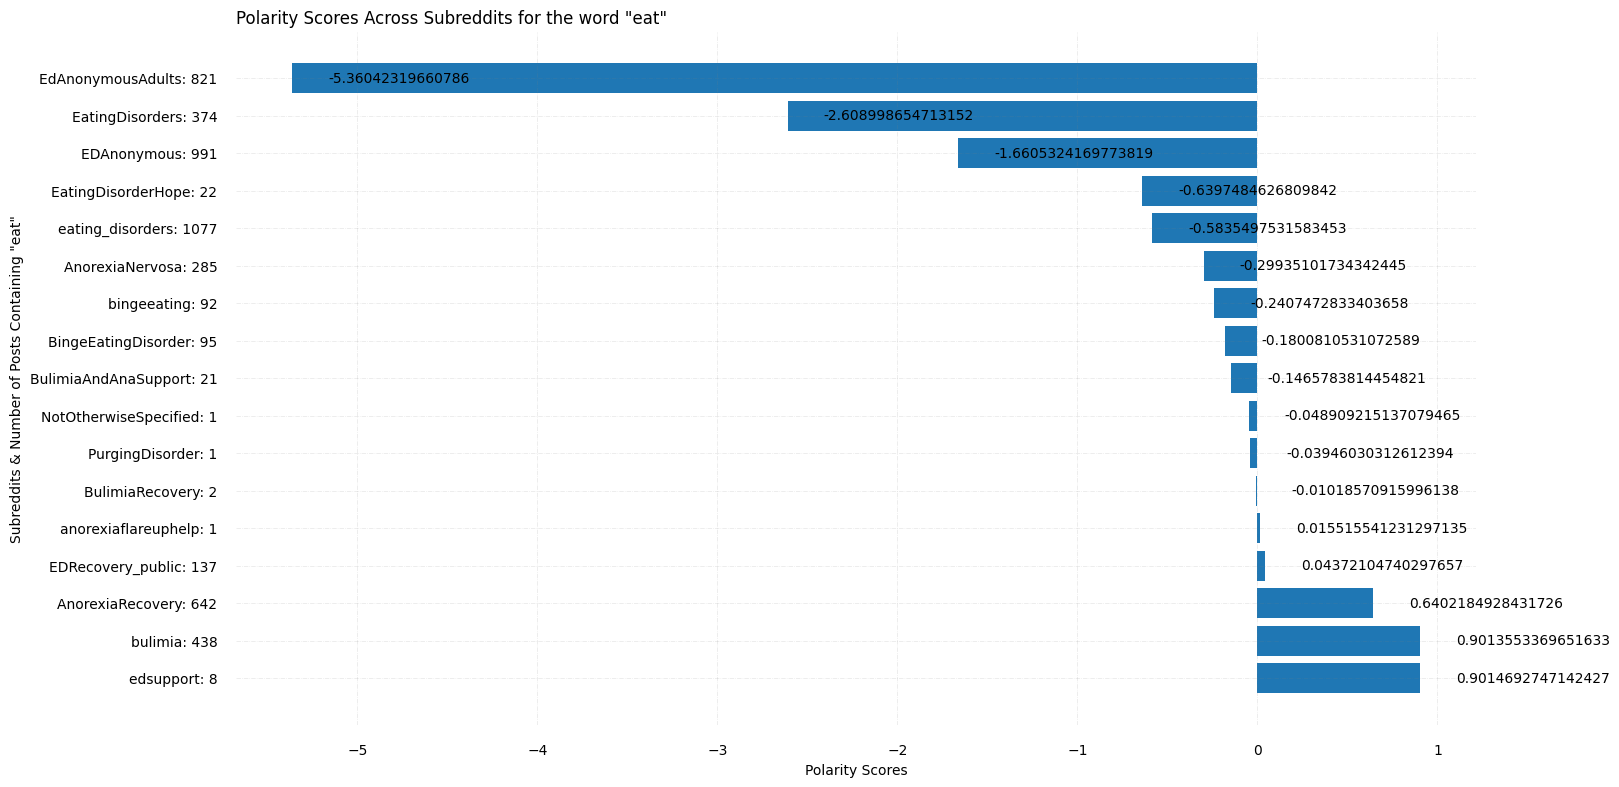

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


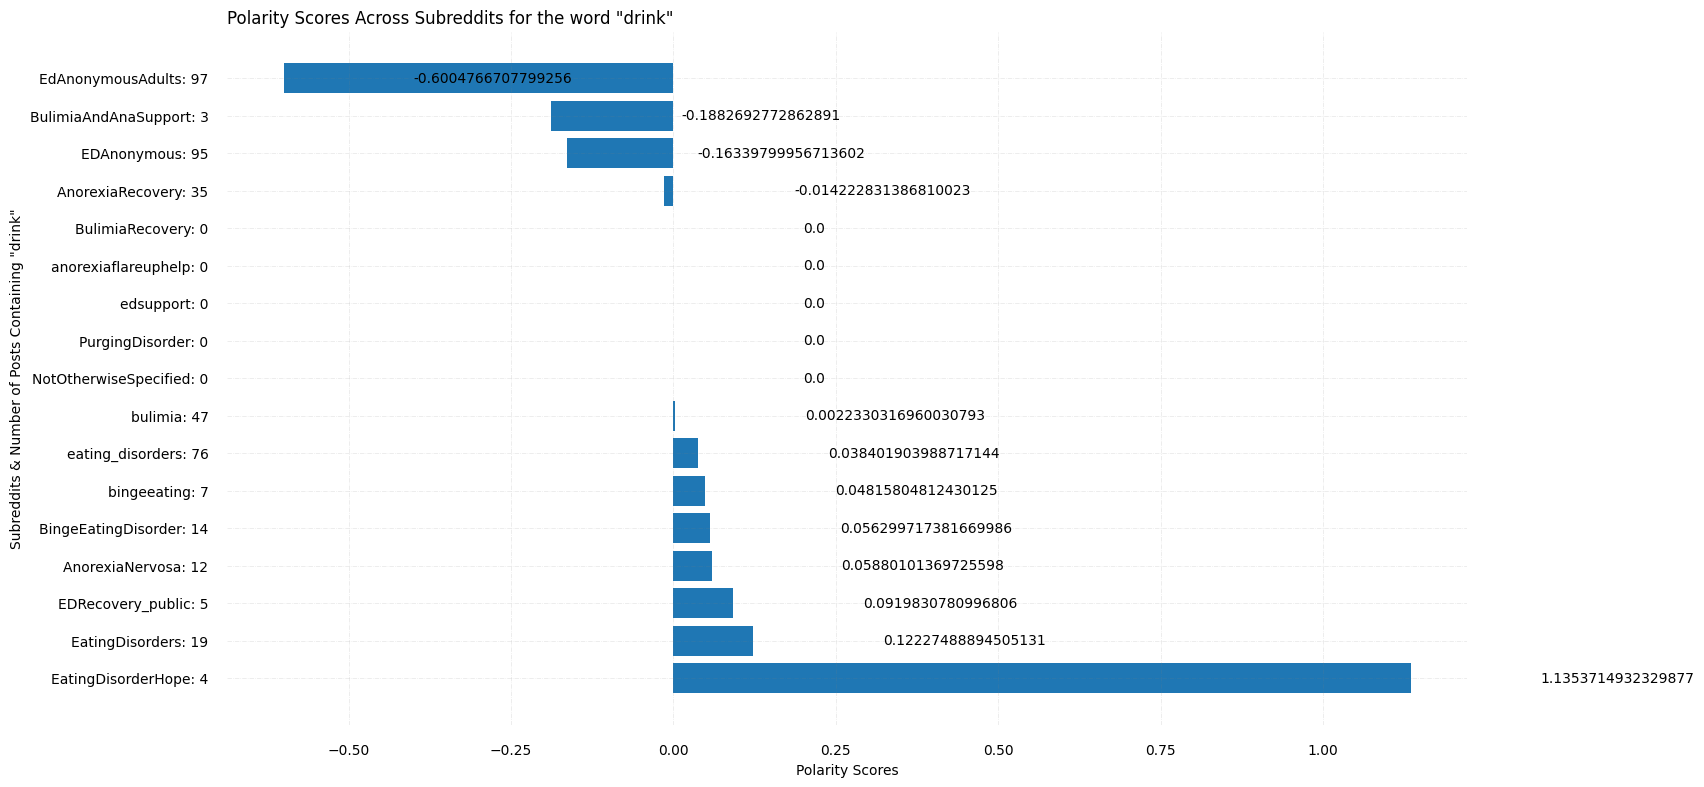

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


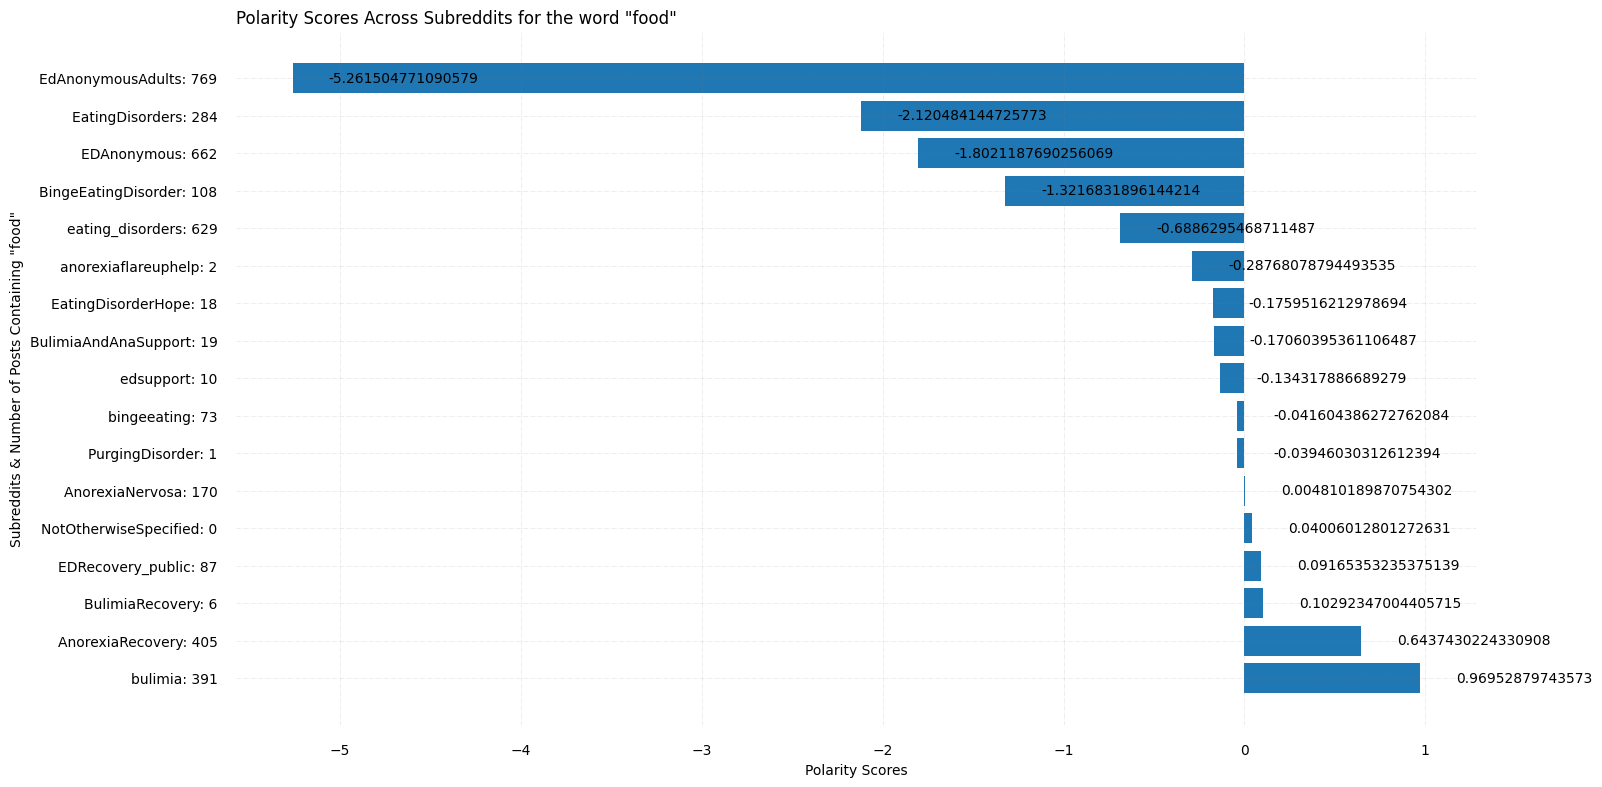

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


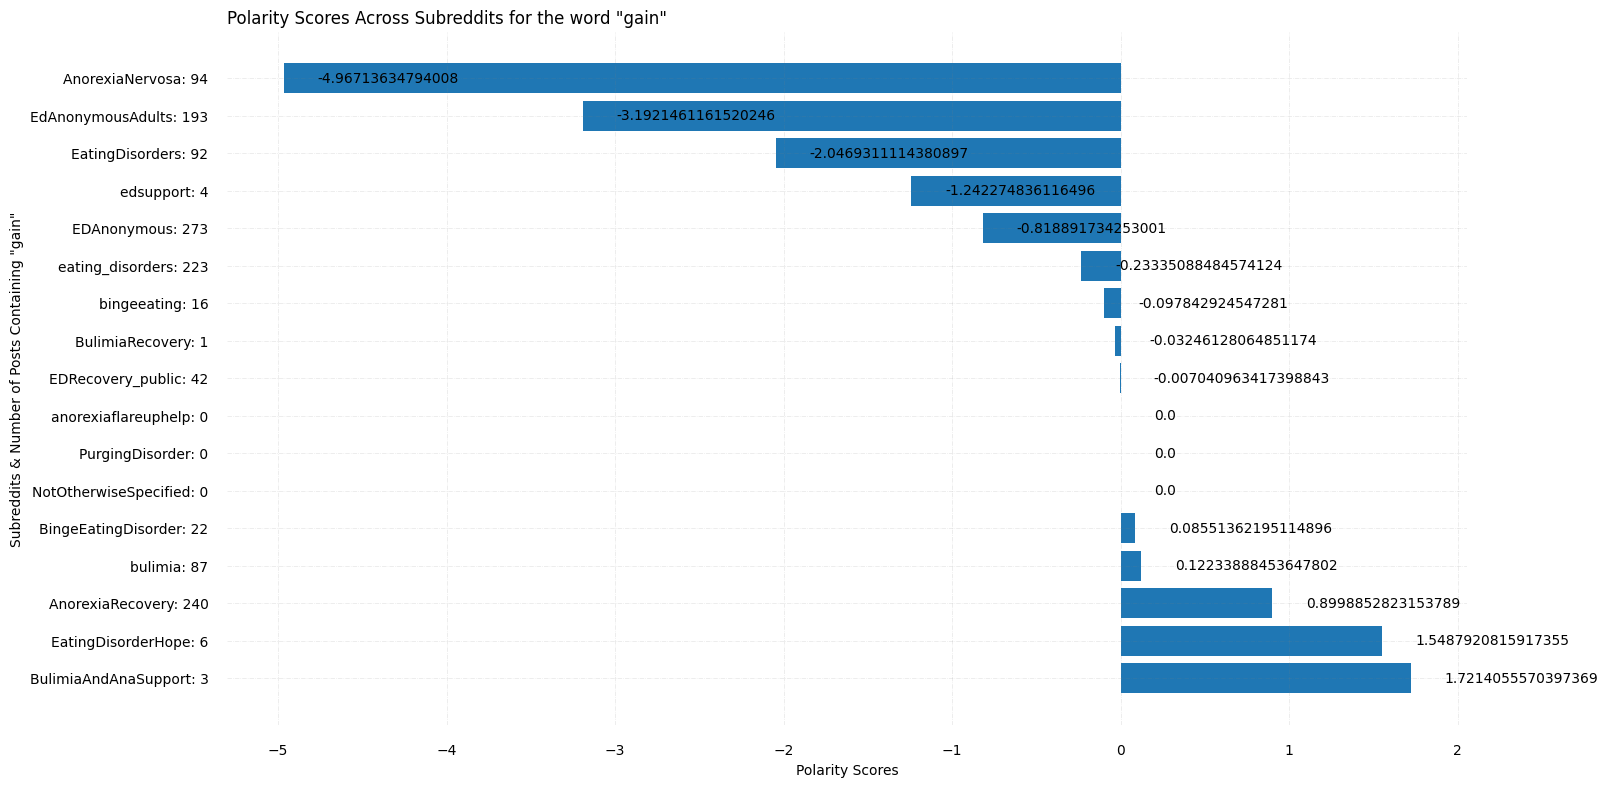

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


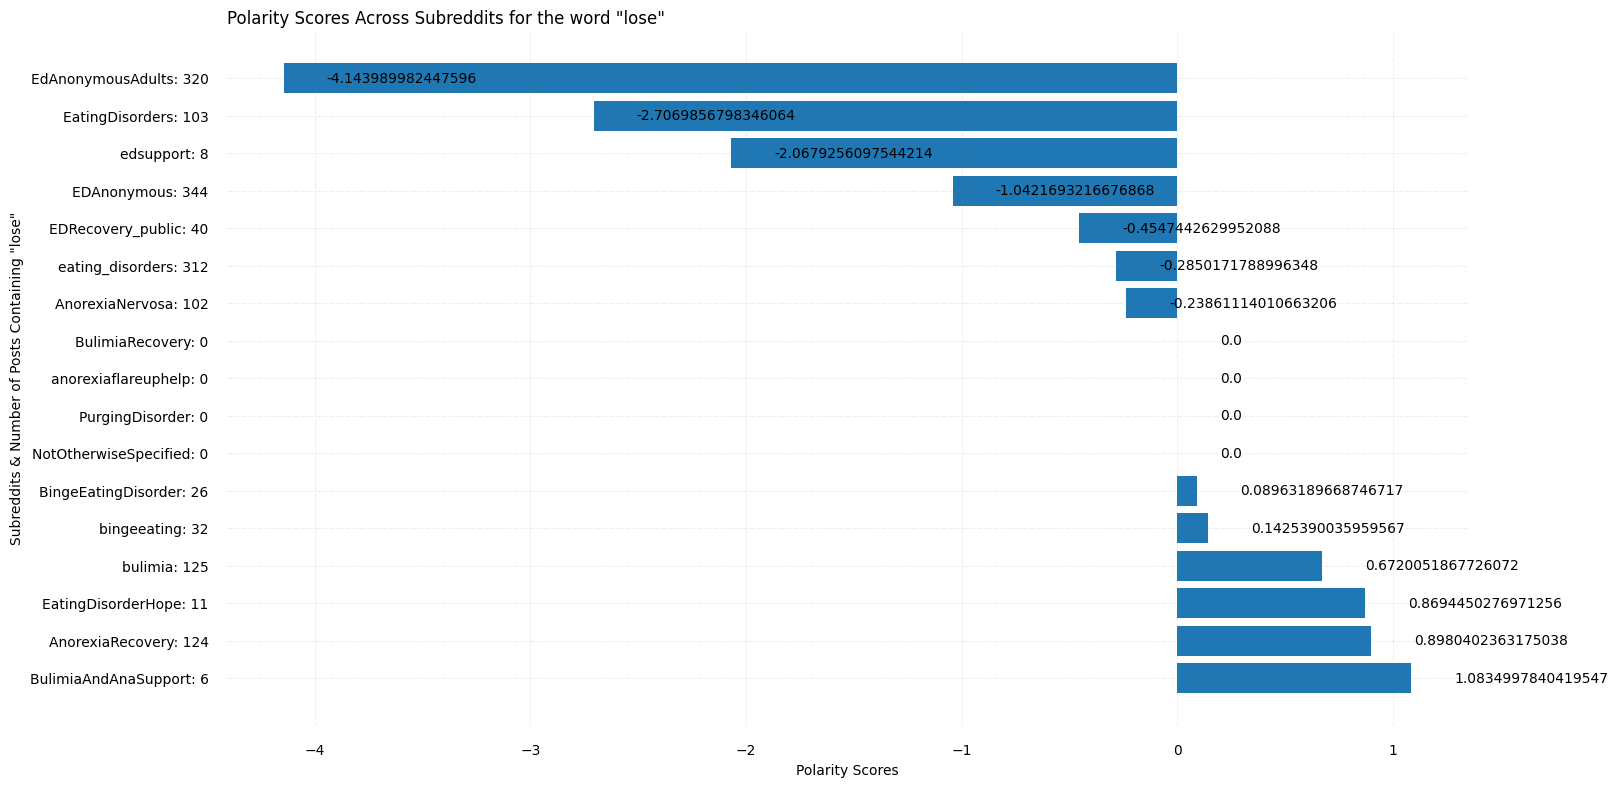

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


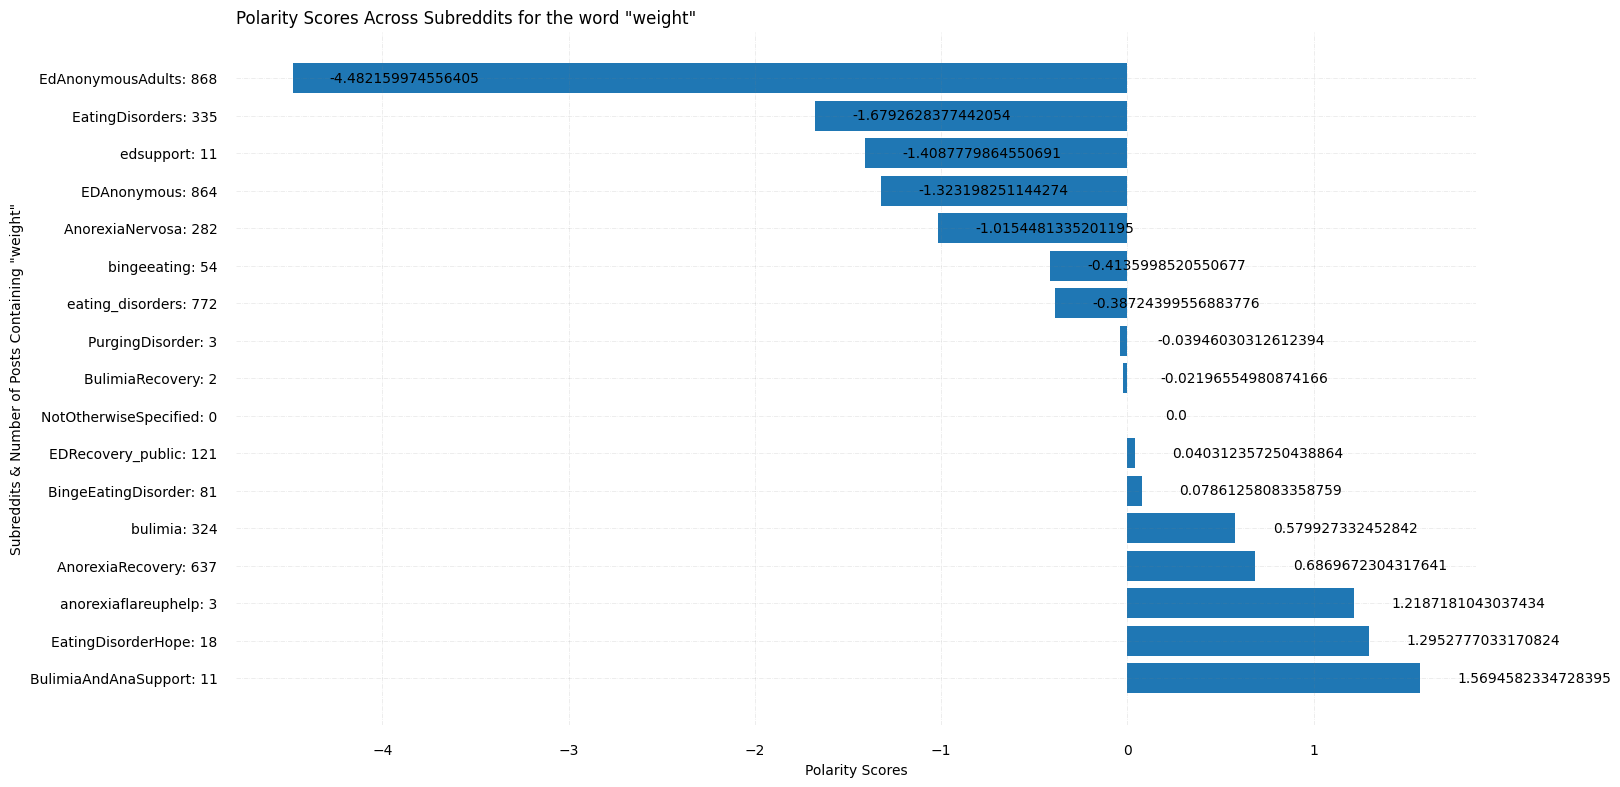

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


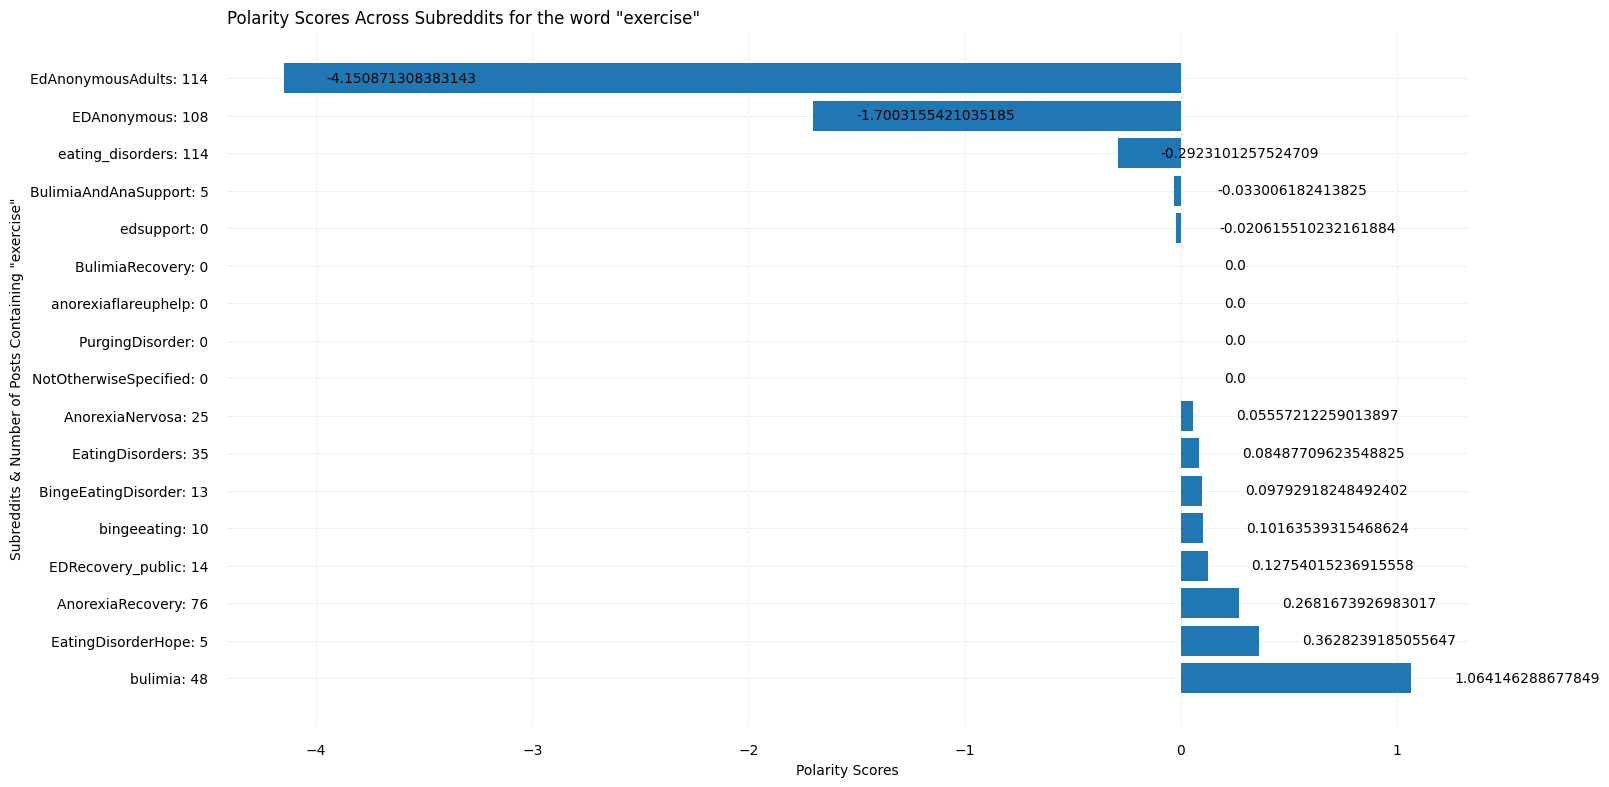

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


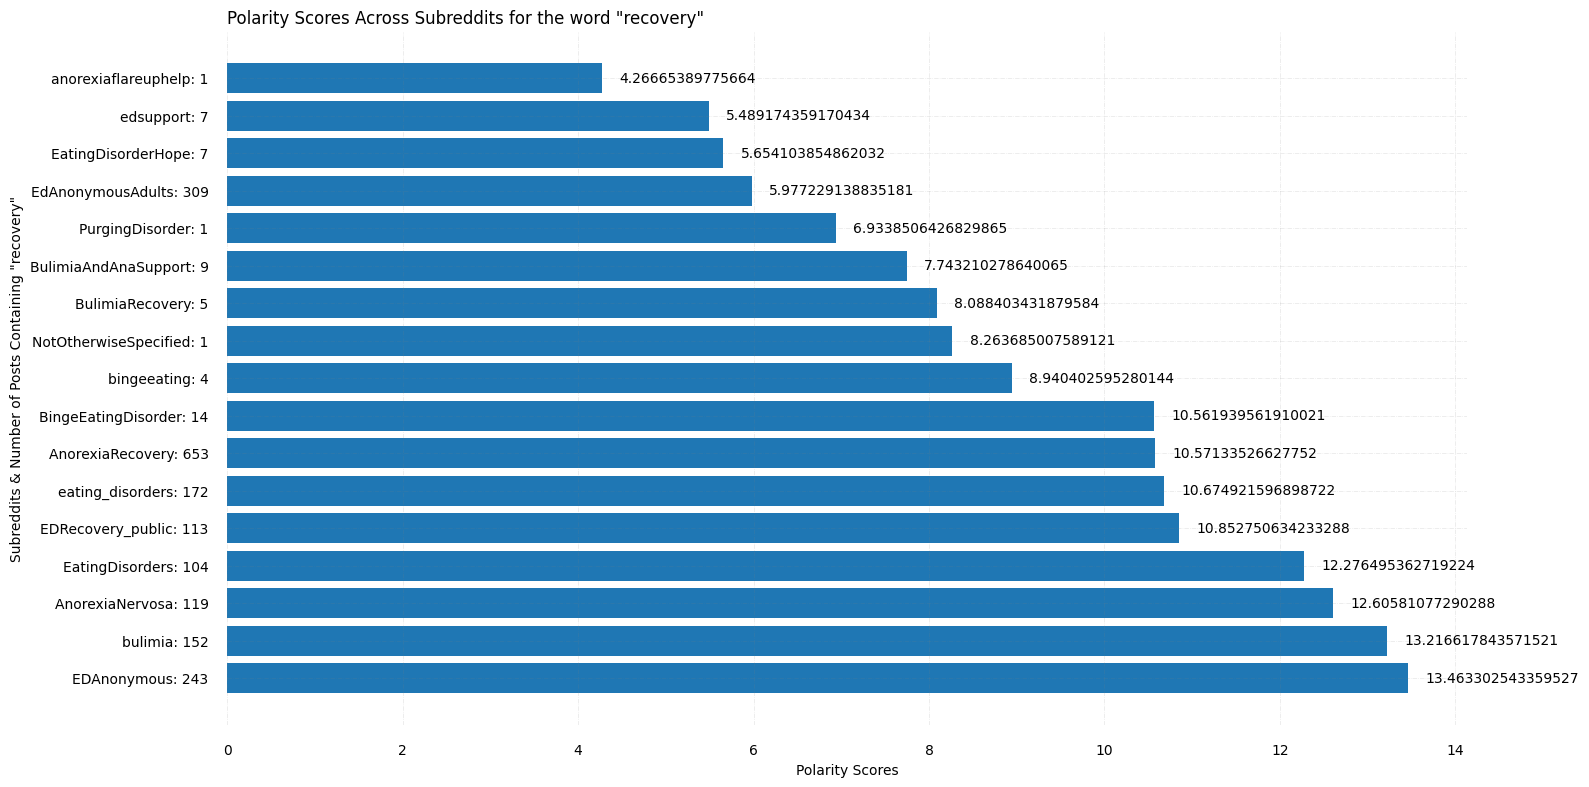

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


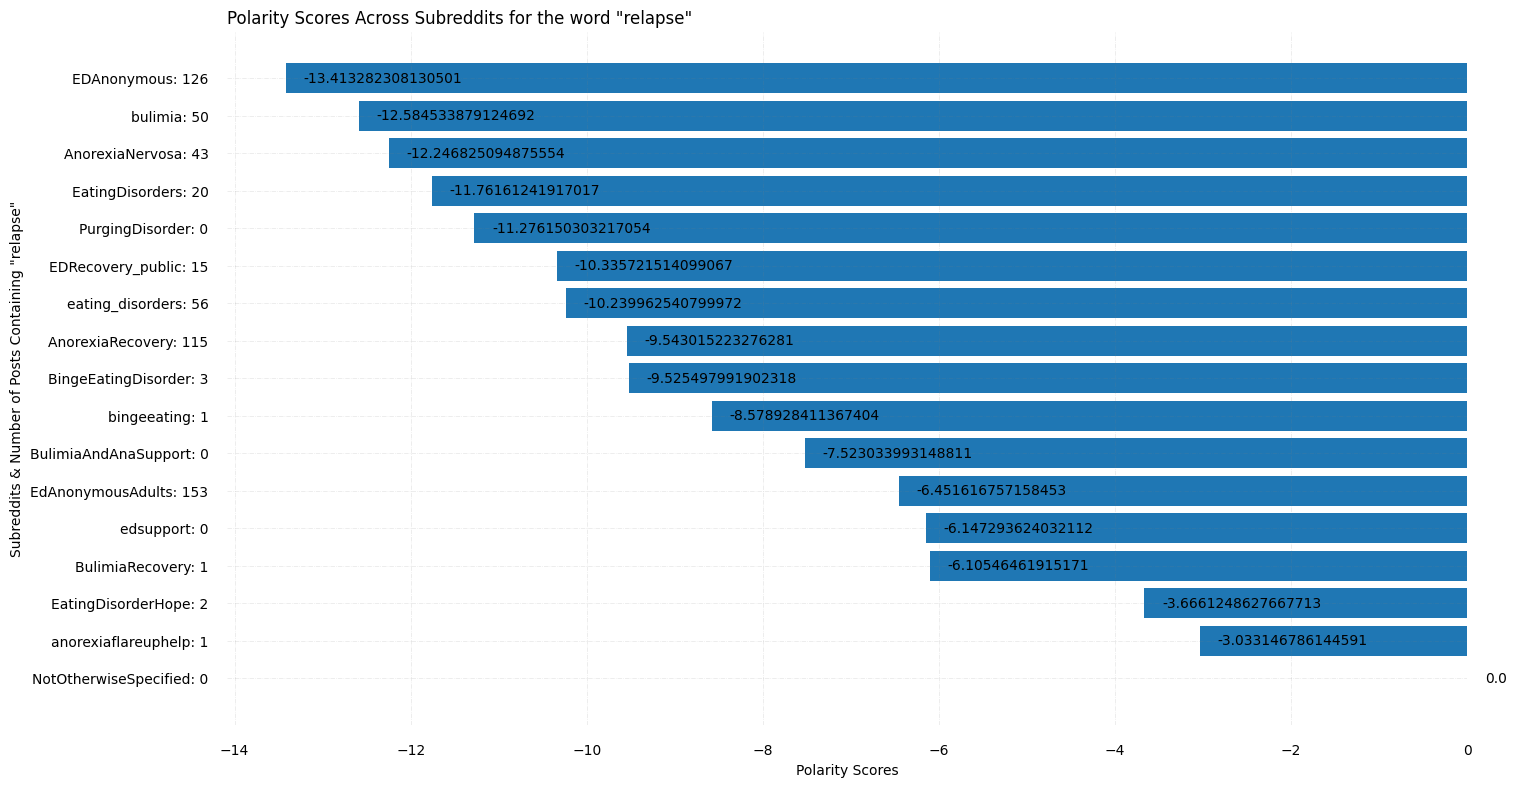

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


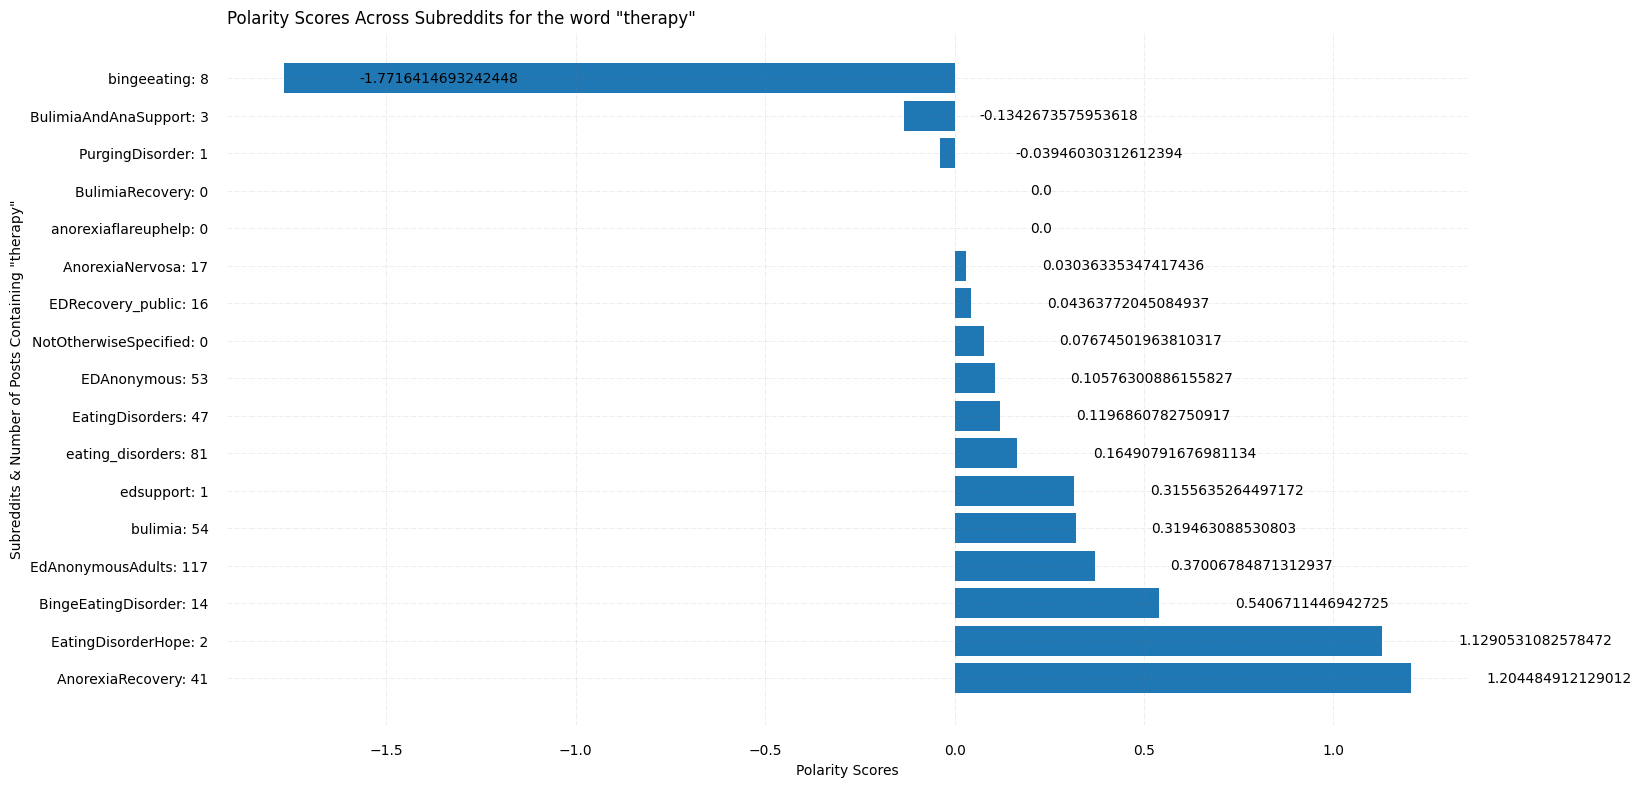

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


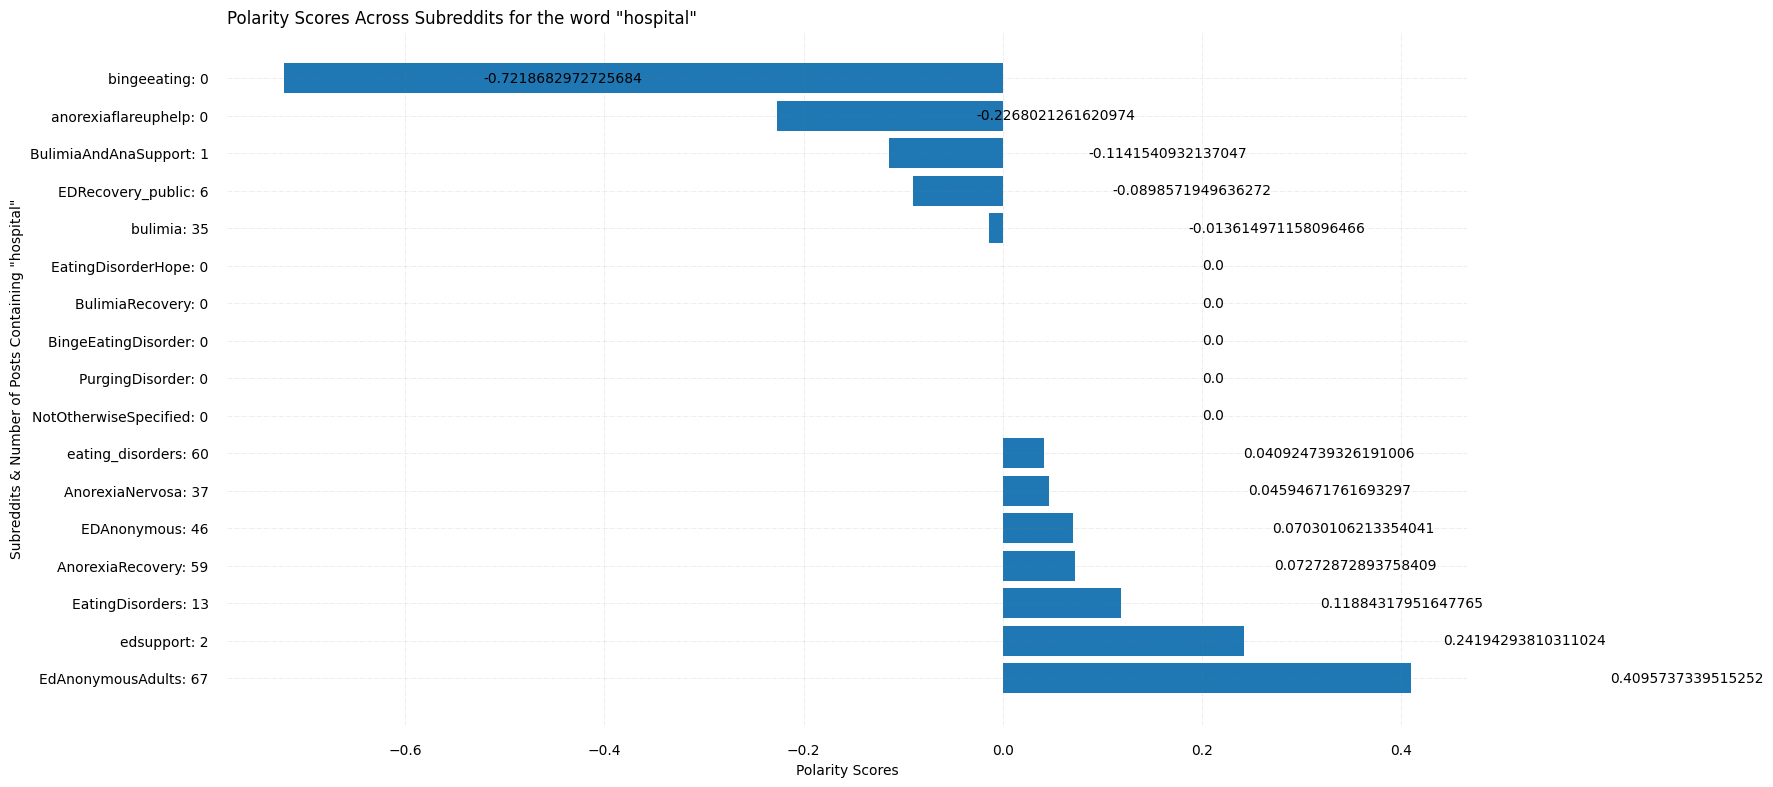

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


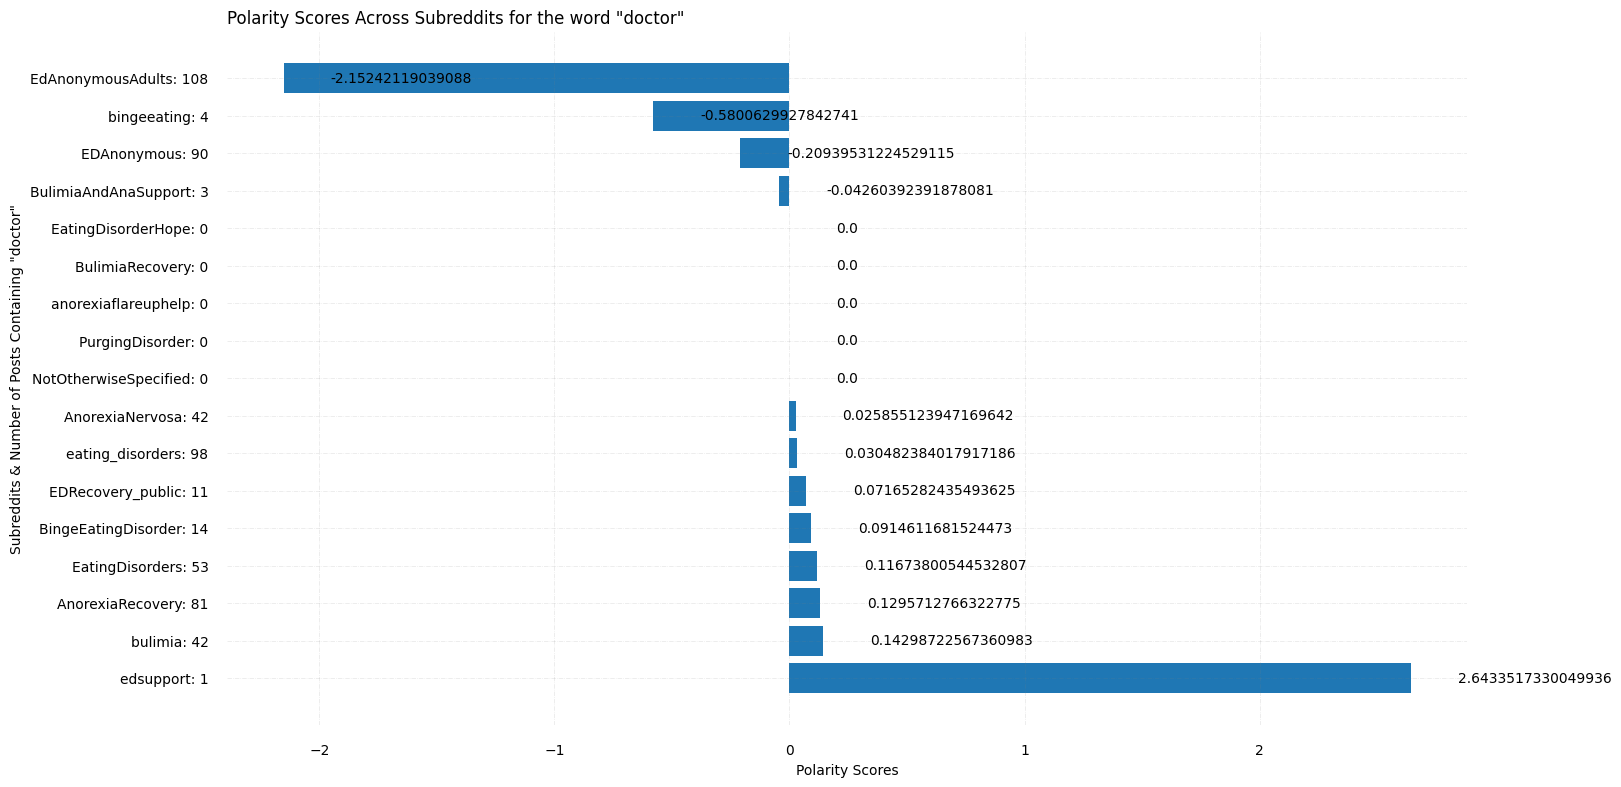

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


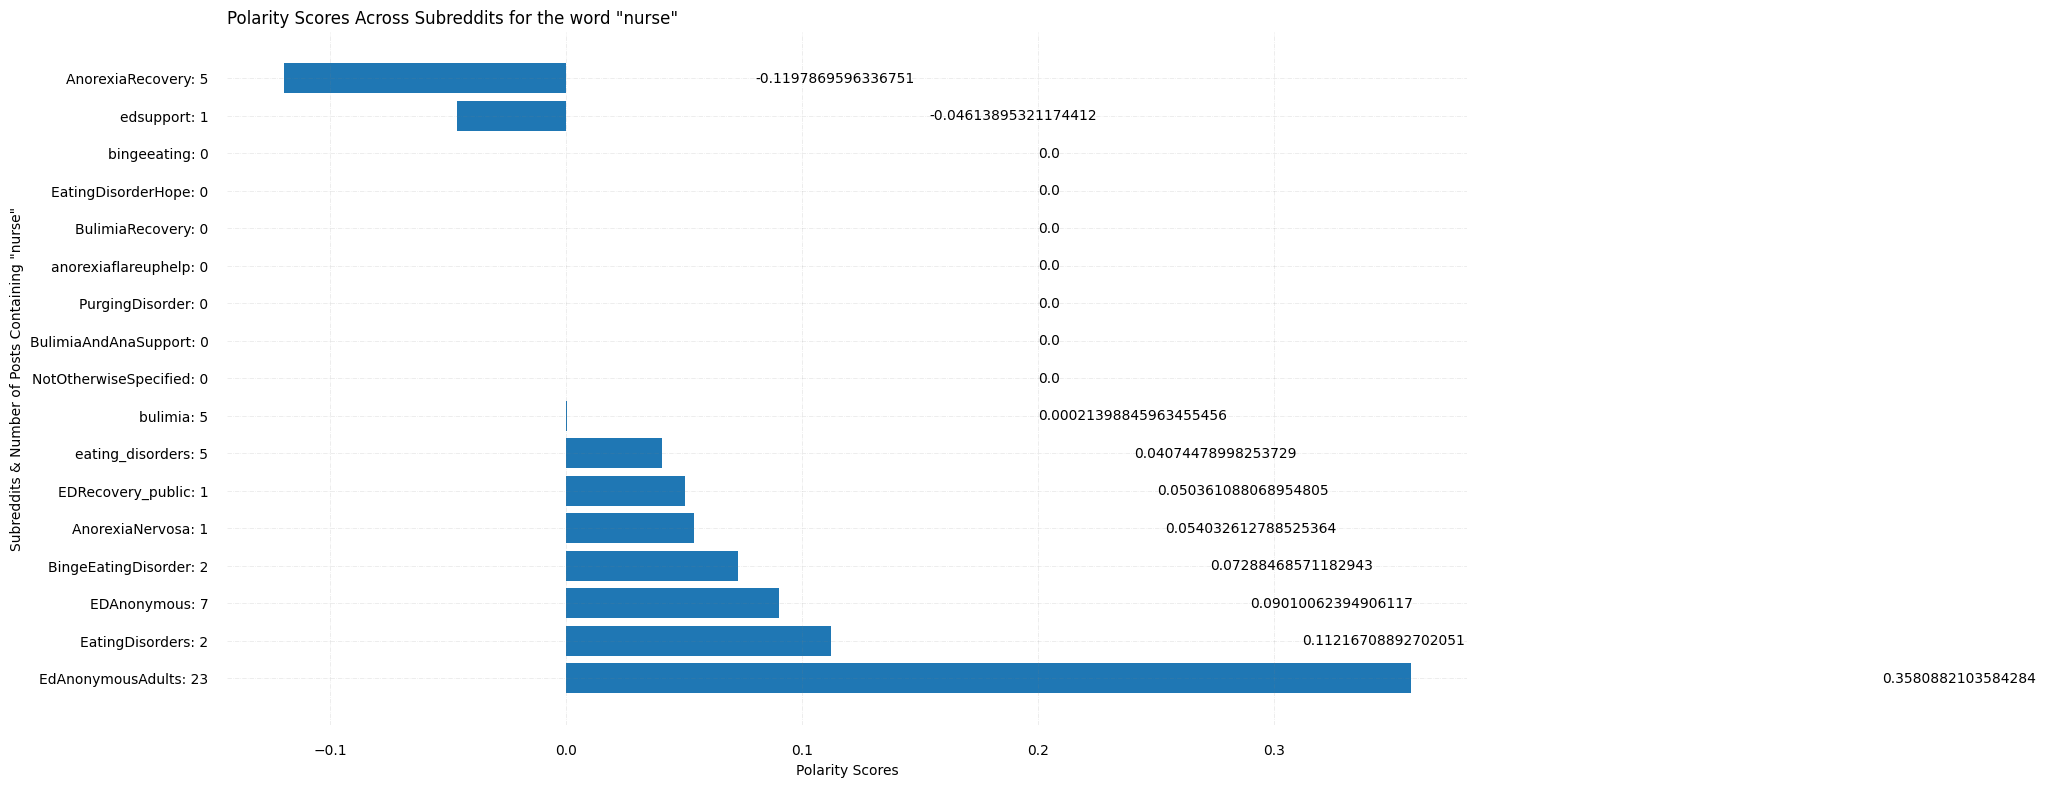

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


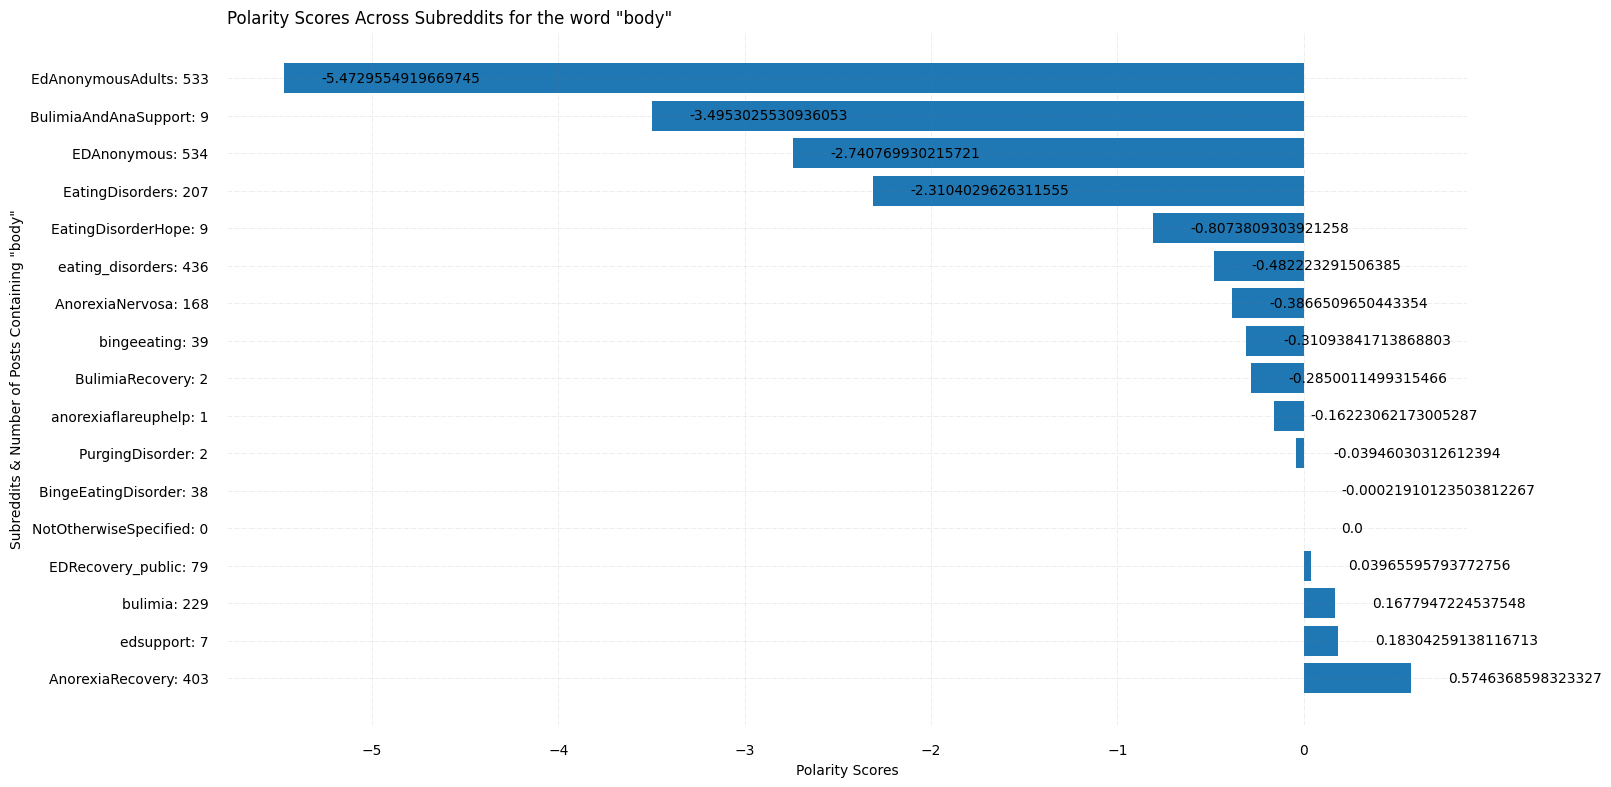

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


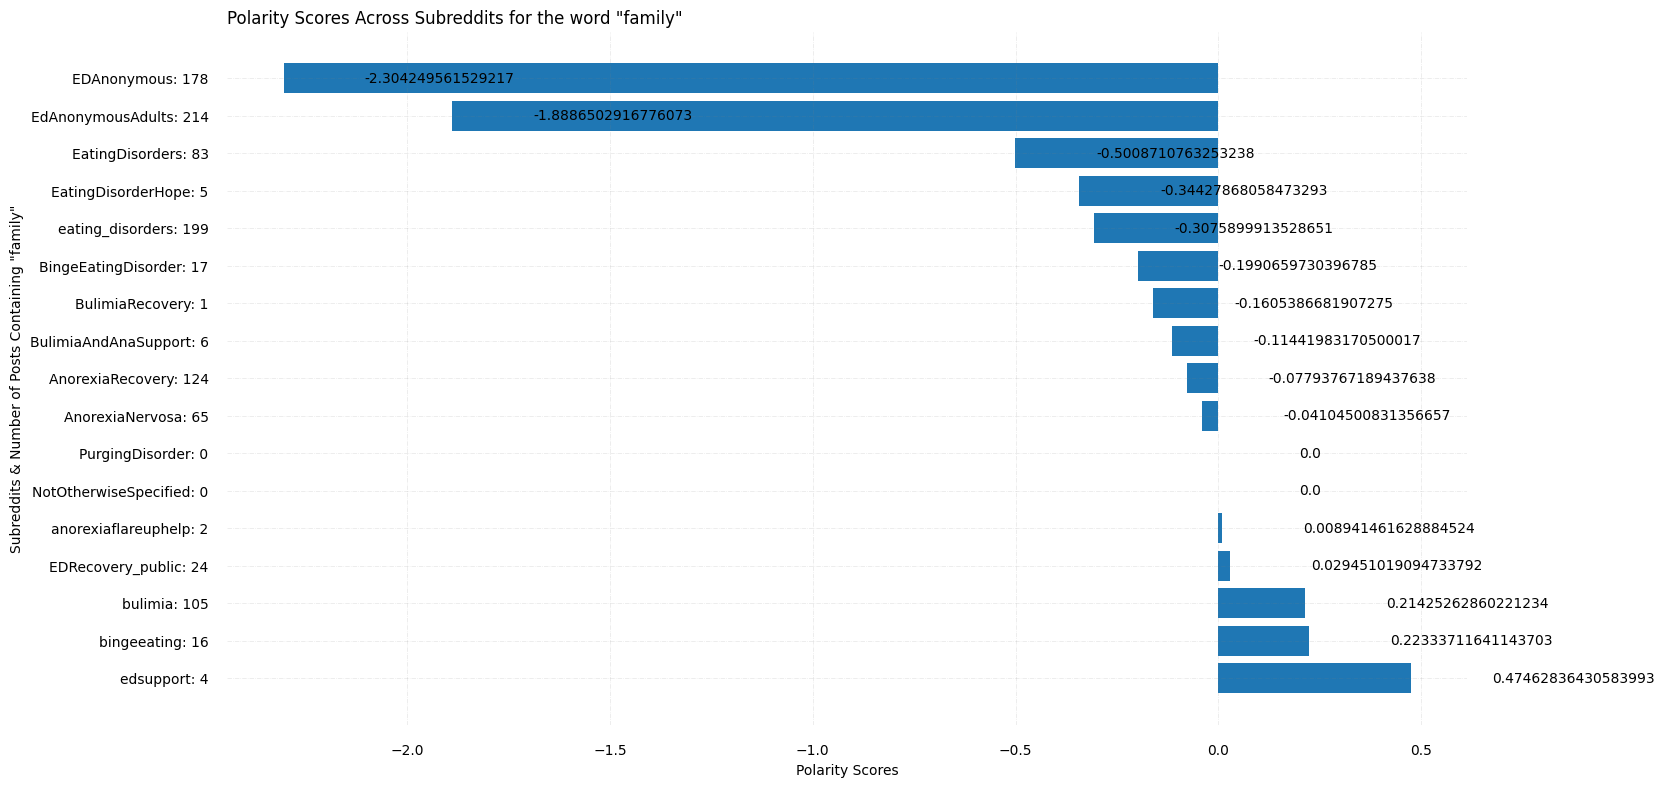

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


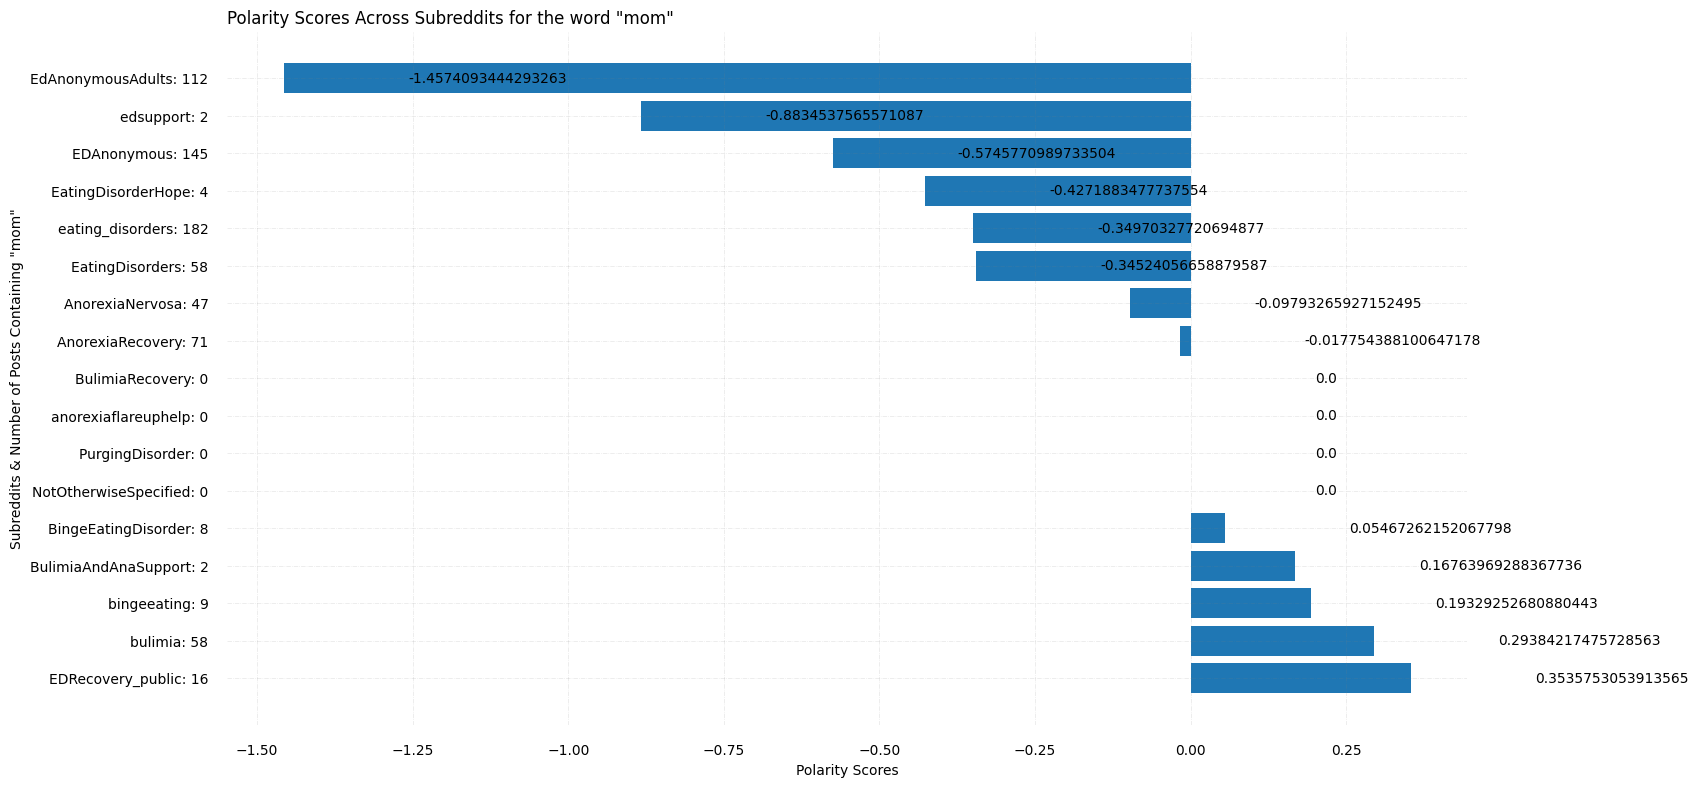

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


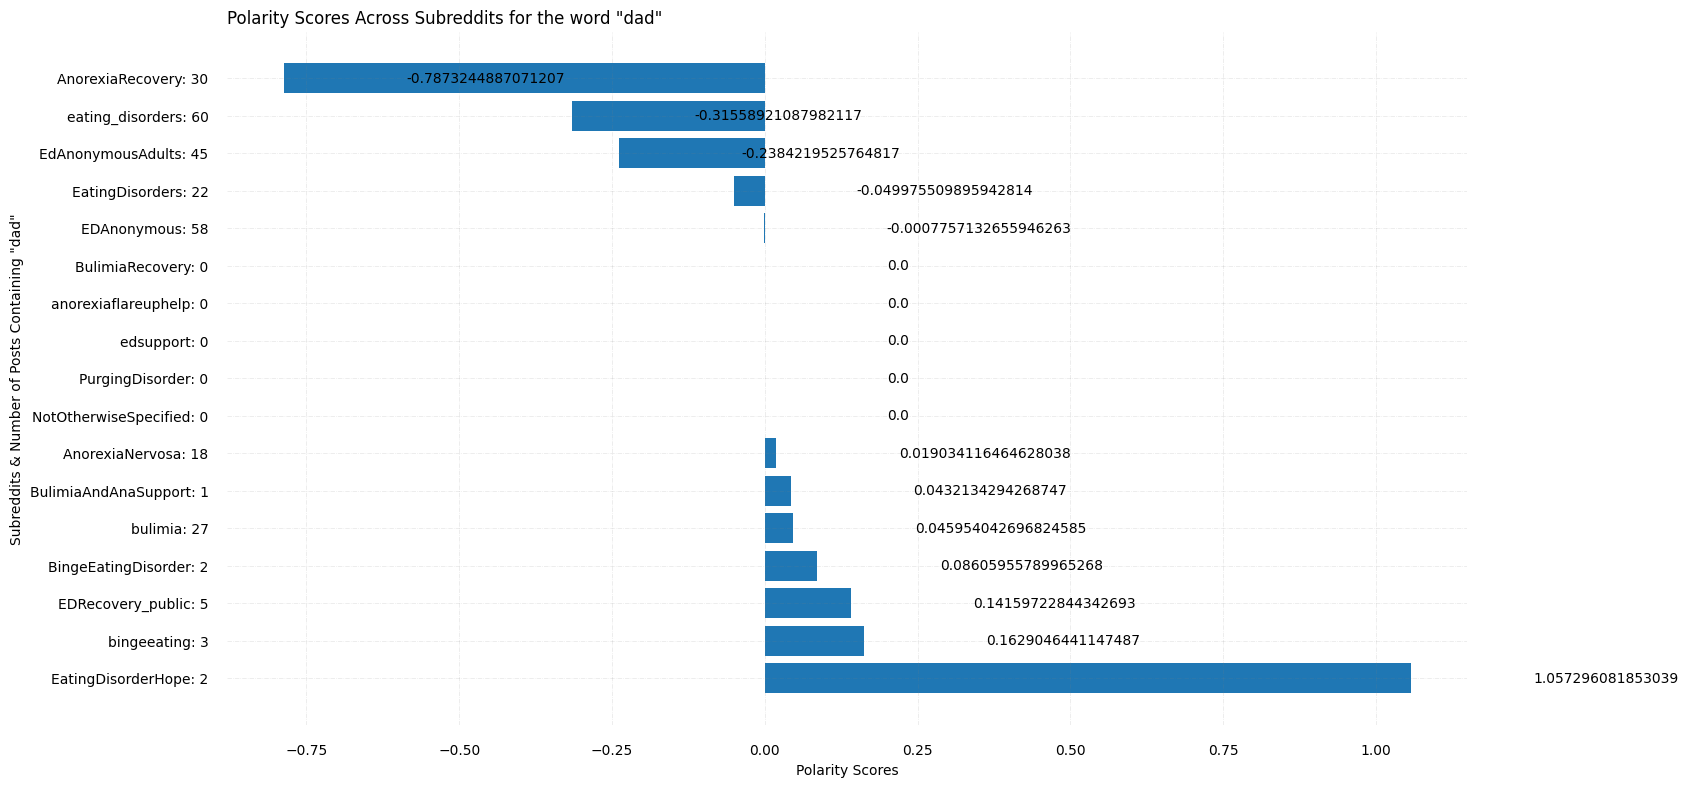

In [20]:
for keyword in keyword_scores.keys():
    subreddits = list(keyword_scores[keyword].keys())
    polarities = list(keyword_scores[keyword].values())

    
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(subreddits, polarities)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 10)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(i.get_width()),
                 fontsize = 10,
                 color ='black')

    # Add Plot Title
    ax.set_title(f'Polarity Scores Across Subreddits for the word "{keyword}"',
                 loc ='left', )
    plt.ylabel(f'Subreddits & Number of Posts Containing "{keyword}"')
    plt.xlabel("Polarity Scores")

    # Show Plot
    plt.show()


In [18]:
score_diffs = dict() # AnorexiaRecovery - BingeEatingDisorder
for word in keyword_scores:
    subreddit_1_score = 0 # AnorexiaRecovery
    subreddit_2_score = 0 # BingeEatingDisorder
    for sub in keyword_scores[word]:
        sub_name = sub.split(":")[0]
        if sub_name == 'AnorexiaRecovery':
            try:
                subreddit_1_score = subreddit_polarities[sub_name][word]
            except:
                subreddit_1_score = 0
        if sub_name == 'BingeEatingDisorder':
            try:
                subreddit_2_score = subreddit_polarities[sub_name][word]
            except:
                subreddit_2_score = 0
    score_diffs[word] = subreddit_1_score - subreddit_2_score

In [19]:
score_diffs

{'eat': 0.8202995459504314,
 'drink': -0.07052254876848,
 'food': 1.9654262120475123,
 'gain': 0.8143716603642299,
 'lose': 0.8084083396300367,
 'weight': 0.6083546495981765,
 'exercise': 0.17023821021337768,
 'recovery': 0.009395704367499036,
 'relapse': -0.017517231373963327,
 'therapy': 0.6638137674347395,
 'hospital': 0.07272872893758409,
 'doctor': 0.03811010847983019,
 'nurse': -0.19267164534550452,
 'body': 0.5748559610673708,
 'family': 0.12112830114530211,
 'mom': -0.07242700962132516,
 'dad': -0.8733840466067734}

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_38172/2305061175.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


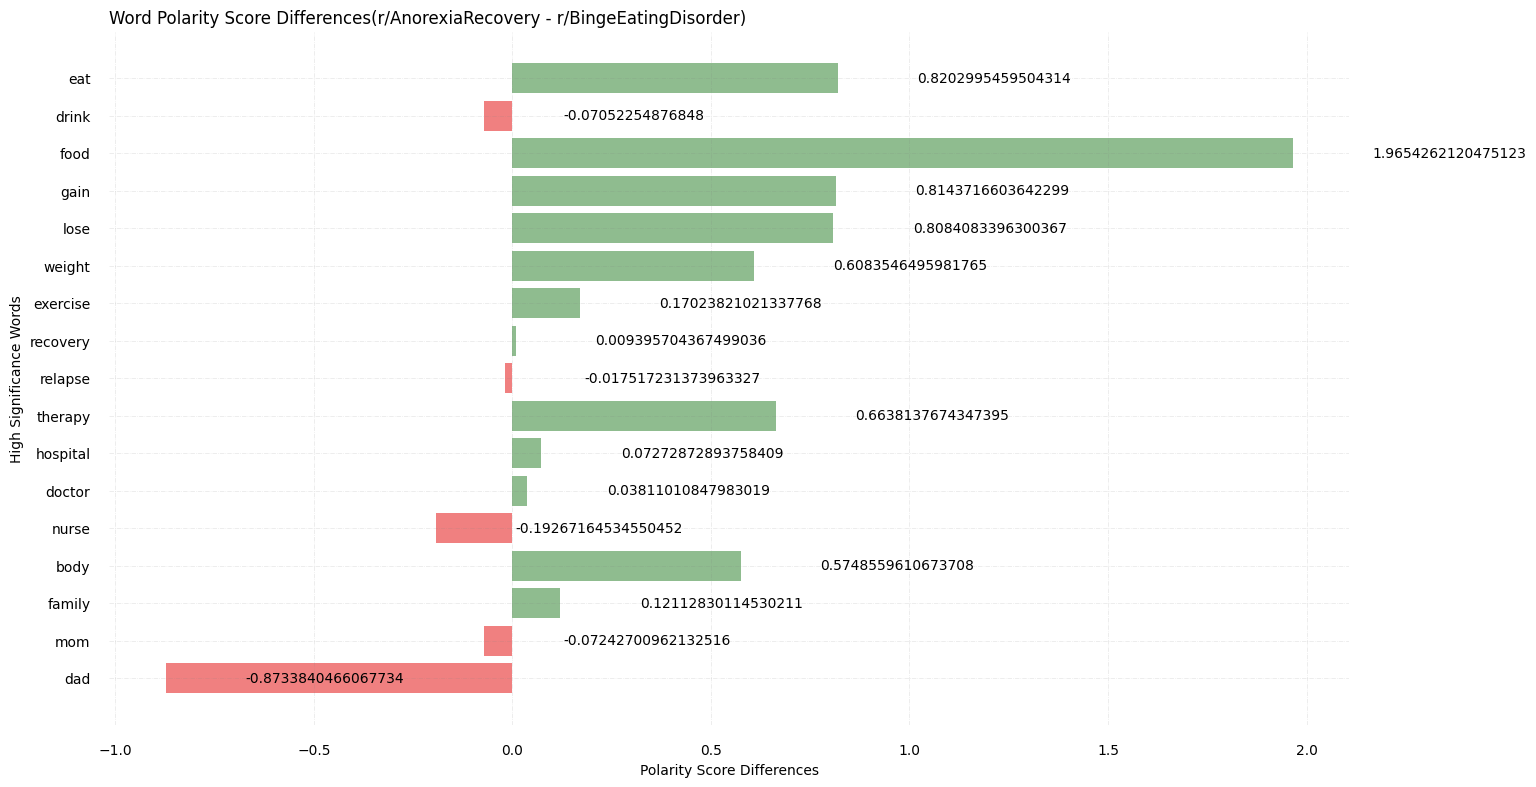

<Figure size 640x480 with 0 Axes>

In [51]:
# for keyword in keyword_scores.keys():
#     subreddits = list(keyword_scores[keyword].keys())
#     polarities = list(keyword_scores[keyword].values())

    
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(list(score_diffs.keys()), list(score_diffs.values()), color=(np.where(np.array(list(score_diffs.values()))>0, 'darkseagreen','lightcoral')))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(i.get_width()),
             fontsize = 10,
             color ='black')

# Add Plot Title
ax.set_title(f'Word Polarity Score Differences(r/AnorexiaRecovery - r/BingeEatingDisorder)',
             loc ='left', )
plt.ylabel(f'High Significance Words')
plt.xlabel("Polarity Score Differences")

# Show Plot
plt.show()
plt.savefig('score_differences_bar_chart.png', bbox_inches="tight",
            pad_inches=0.3, transparent=True)


/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_38172/863453983.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


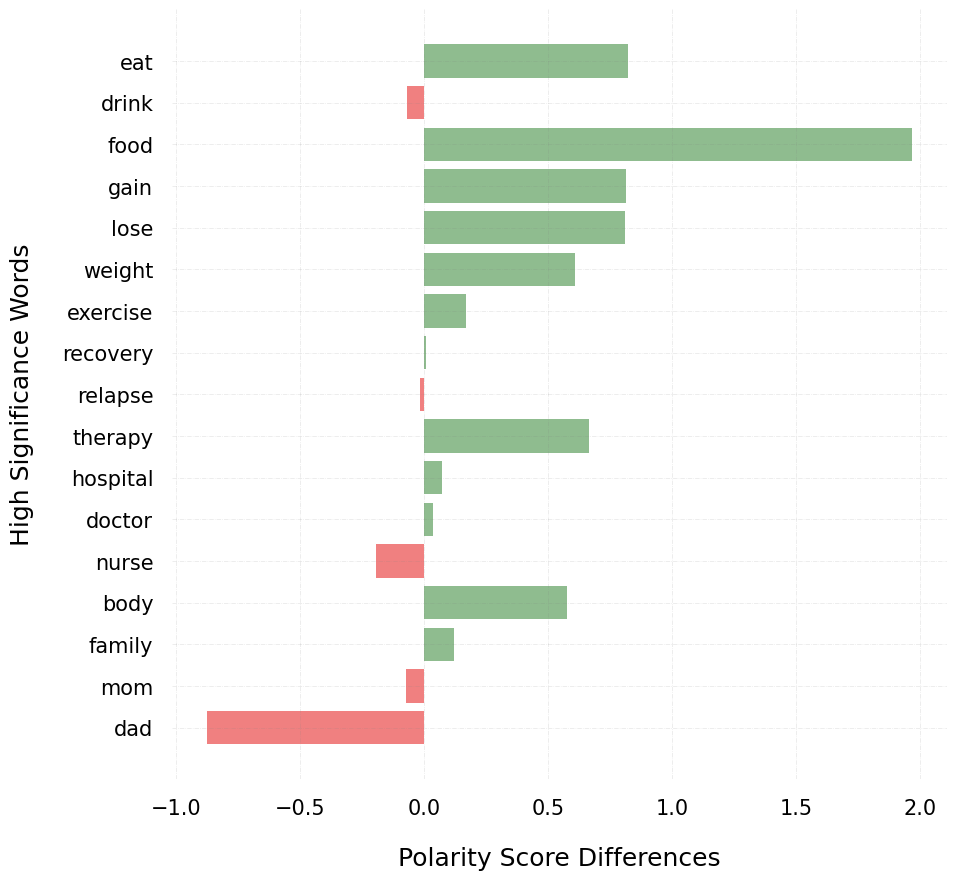

<Figure size 640x480 with 0 Axes>

In [69]:
# for keyword in keyword_scores.keys():
#     subreddits = list(keyword_scores[keyword].keys())
#     polarities = list(keyword_scores[keyword].values())

    
# Figure Size
fig, ax = plt.subplots(figsize =(10, 10))

# Horizontal Bar Plot
ax.barh(list(score_diffs.keys()), list(score_diffs.values()), color=(np.where(np.array(list(score_diffs.values()))>0, 'darkseagreen','lightcoral')))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(i.get_width()),
#              fontsize = 10,
#              color ='black')

# Add Plot Title
# ax.set_title(f'Word Polarity Score Differences(r/AnorexiaRecovery - r/BingeEatingDisorder)',
#              loc ='center', )
plt.ylabel(f'High Significance Words',fontsize=18,labelpad=20)
plt.xlabel("Polarity Score Differences",fontsize=18,labelpad=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# Show Plot
plt.show()
plt.savefig('score_differences_bar_chart.png', bbox_inches="tight",
            pad_inches=0.3, transparent=True)


In [15]:
score_diffs = dict() # AnorexiaRecovery - EdAnonymousAdults
for word in keyword_scores:
    subreddit_1_score = 0 # AnorexiaRecovery
    subreddit_2_score = 0 # EdAnonymousAdults
    for sub in keyword_scores[word]:
        sub_name = sub.split(":")[0]
        if sub_name == 'AnorexiaRecovery':
            try:
                subreddit_1_score = subreddit_polarities[sub_name][word]
            except:
                subreddit_1_score = 0
        if sub_name == 'EdAnonymousAdults':
            try:
                subreddit_2_score = subreddit_polarities[sub_name][word]
            except:
                subreddit_2_score = 0
    score_diffs[word] = subreddit_1_score - subreddit_2_score

In [16]:
score_diffs

{'eat': 6.000641689451032,
 'drink': 0.5862538393931156,
 'food': 5.90524779352367,
 'gain': 4.0920313984674035,
 'lose': 5.0420302187651,
 'weight': 5.169127204988169,
 'exercise': 4.419038701081445,
 'recovery': 4.594106127442339,
 'relapse': -3.0913984661178286,
 'therapy': 0.8344170634158826,
 'hospital': -0.3368450050139411,
 'doctor': 2.2819924670231573,
 'nurse': -0.4778751699921035,
 'body': 6.047592351799307,
 'family': 1.810712619783231,
 'mom': 1.4396549563286791,
 'dad': -0.548902536130639}

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_54063/863453983.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


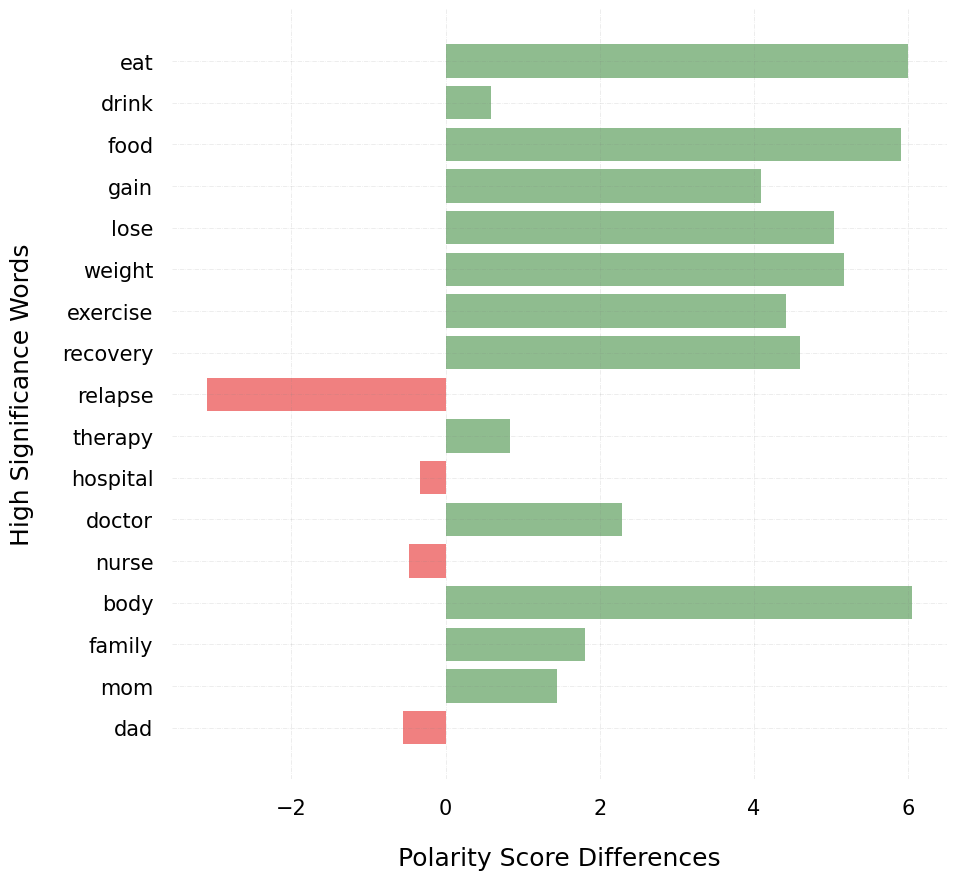

<Figure size 640x480 with 0 Axes>

In [18]:
# for keyword in keyword_scores.keys():
#     subreddits = list(keyword_scores[keyword].keys())
#     polarities = list(keyword_scores[keyword].values())

    
# Figure Size
fig, ax = plt.subplots(figsize =(10, 10))

# Horizontal Bar Plot
ax.barh(list(score_diffs.keys()), list(score_diffs.values()), color=(np.where(np.array(list(score_diffs.values()))>0, 'darkseagreen','lightcoral')))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(i.get_width()),
#              fontsize = 10,
#              color ='black')

# Add Plot Title
# ax.set_title(f'Word Polarity Score Differences(r/AnorexiaRecovery - r/BingeEatingDisorder)',
#              loc ='center', )
plt.ylabel(f'High Significance Words',fontsize=18,labelpad=20)
plt.xlabel("Polarity Score Differences",fontsize=18,labelpad=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# Show Plot
plt.show()
plt.savefig('score_differences_bar_chart.png', bbox_inches="tight",
            pad_inches=0.3, transparent=True)


In [ ]:
subreddit_polarity